#Image Classification

In [1]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Class: banana
Confidence Score: 0.6735787


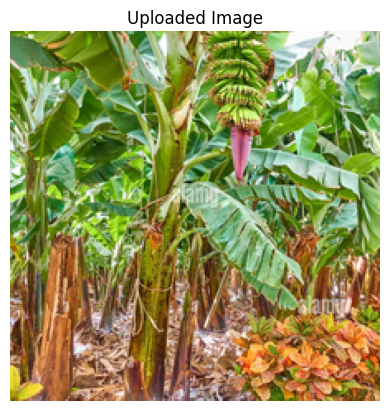

In [2]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np
from keras.layers import DepthwiseConv2D
import matplotlib.pyplot as plt


class PatchedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop("groups", None)  # Remove unsupported 'groups' argument
        super().__init__(*args, **kwargs)

# Custom loader with patched class
def load_model_with_patch(model_path):
    custom_objects = {'DepthwiseConv2D': PatchedDepthwiseConv2D}
    return load_model(model_path, compile=False, custom_objects=custom_objects)

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model_with_patch("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Image/keras_model.h5")

# Load the labels
class_names = open("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Image/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Image/Image.jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

#Video Classification

In [11]:
from google.colab import drive
drive.flush_and_unmount()  # Unmount Drive
drive.mount('/content/drive')  # Mount again


Mounted at /content/drive


In [10]:
# ✅ Teachable Machine Video Classifier with Upload Support in Colab

# STEP 1: UPLOAD A VIDEO FILE (INSTEAD OF WEBCAM)
from google.colab import files

print("📤 Upload a video file (MP4, WebM, etc.)")
uploaded_video = files.upload()
video_path = next(iter(uploaded_video))
print(f"✅ Video uploaded: {video_path}")


# STEP 2: LOAD MODEL AND LABELS FROM SPECIFIED PATHS
from keras.models import load_model
from keras.layers import DepthwiseConv2D

# Patch DepthwiseConv2D for TM models
def load_model_with_patch(path):
    class PatchedDepthwiseConv2D(DepthwiseConv2D):
        def __init__(self, *args, **kwargs):
            kwargs.pop("groups", None)
            super().__init__(*args, **kwargs)

    return load_model(path, compile=False, custom_objects={'DepthwiseConv2D': PatchedDepthwiseConv2D})

# Load the model and labels directly from path
model = load_model_with_patch("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Video/keras_model.h5")
class_names = [line.strip() for line in open("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Video/labels.txt", "r").readlines()]


# STEP 3: PROCESS VIDEO AND CLASSIFY FRAMES
import cv2
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("❌ Couldn't open uploaded video. Please try another format or re-upload.")

frame_skip = 1  # process every frame
frame_count = 0

predictions_log = []

print("\n--- Predictions ---")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    print("Processing frame:", frame_count)

    if frame_count % frame_skip != 0:
        continue

    # Convert to PIL Image
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = ImageOps.fit(img, (224, 224), Image.Resampling.LANCZOS)
    img_array = np.asarray(img)
    normalized = (img_array.astype(np.float32) / 127.5) - 1

    data = np.ndarray((1, 224, 224, 3), dtype=np.float32)
    data[0] = normalized

    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]

    print(f"[Frame {frame_count}] {class_name.strip()} ({confidence*100:.2f}%)")

    predictions_log.append({
        "frame": frame_count,
        "class": class_name.strip(),
        "confidence": round(confidence * 100, 2)
    })

    # Optional: Display frame
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_name.strip()} ({confidence*100:.1f}%)")
    plt.show()

cap.release()

# STEP 4: SAVE CSV
if predictions_log:
    pred_df = pd.DataFrame(predictions_log)
    pred_df.to_csv("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Video/video_predictions.csv", index=False)
    print("\n✅ Predictions saved to video_predictions.csv")
else:
    print("\n⚠️ No predictions were made. CSV not created.")


Output hidden; open in https://colab.research.google.com to view.

# Audio Classification

In [4]:
# ✅ Teachable Machine Audio Classifier in Colab

# STEP 1: UPLOAD AUDIO FILE
from google.colab import files
print("📤 Upload an audio file (.wav, .mp3, etc.)")
audio_upload = files.upload()
audio_path = next(iter(audio_upload))
print(f"✅ Audio uploaded: {audio_path}")


# STEP 2: LOAD TFLITE MODEL AND LABELS
import tensorflow as tf
import numpy as np
import os
import librosa
import pandas as pd

# Define paths
MODEL_PATH = "/content/drive/My Drive/kerashub-teachable-machines/Teachable-Audio/soundclassifier_with_metadata.tflite"
LABEL_PATH = "/content/drive/My Drive/kerashub-teachable-machines/Teachable-Audio/labels.txt"

# Load labels
with open(LABEL_PATH, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# STEP 3: PROCESS AUDIO
print("\n🎧 Processing audio and classifying...")

data, sample_rate = librosa.load(audio_path, sr=16000)
data = np.array(data, dtype=np.float32)

# Pad or trim audio
expected_len = input_details[0]['shape'][1]
if len(data) < expected_len:
    data = np.pad(data, (0, expected_len - len(data)))
elif len(data) > expected_len:
    data = data[:expected_len]

data = np.expand_dims(data, axis=0)

# Run inference
interpreter.set_tensor(input_details[0]['index'], data)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0]

# STEP 4: DISPLAY RESULTS
print("\n--- Prediction Results ---")
predictions_log = []
for i, score in enumerate(prediction):
    print(f"{labels[i]}: {score*100:.2f}%")
    predictions_log.append({"label": labels[i], "confidence": round(score * 100, 2)})

# STEP 5: SAVE PREDICTIONS TO CSV
pred_df = pd.DataFrame(predictions_log)
pred_df.to_csv("audio_predictions.csv", index=False)
print("\n✅ Predictions saved to audio_predictions.csv")


📤 Upload an audio file (.wav, .mp3, etc.)


Saving beautiful-piano-amp-guitar-303684.mp3 to beautiful-piano-amp-guitar-303684 (2).mp3
✅ Audio uploaded: beautiful-piano-amp-guitar-303684 (2).mp3

🎧 Processing audio and classifying...

--- Prediction Results ---
0 Background Noise: 6.98%
1 Guitar: 93.02%

✅ Predictions saved to audio_predictions.csv


In [5]:
!pip install sounddevice soundfile


In [12]:
# ✅ Teachable Machine Audio Classifier in Colab

# STEP 1: UPLOAD AUDIO FILE
from google.colab import files
print("📤 Upload an audio file (.wav, .mp3, etc.)")
audio_upload = files.upload()
audio_path = next(iter(audio_upload))
print(f"✅ Audio uploaded: {audio_path}")


# STEP 2: LOAD TFLITE MODEL AND LABELS
import tensorflow as tf
import numpy as np
import os
import librosa
import pandas as pd

# Define paths
MODEL_PATH = "/content/drive/My Drive/kerashub-teachable-machines/Teachable-Audio/soundclassifier_with_metadata.tflite"
LABEL_PATH = "/content/drive/My Drive/kerashub-teachable-machines/Teachable-Audio/labels.txt"

# Load labels
with open(LABEL_PATH, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# STEP 3: PROCESS AUDIO
print("\n🎧 Processing audio and classifying...")

data, sample_rate = librosa.load(audio_path, sr=16000)
data = np.array(data, dtype=np.float32)

# Pad or trim audio
expected_len = input_details[0]['shape'][1]
if len(data) < expected_len:
    data = np.pad(data, (0, expected_len - len(data)))
elif len(data) > expected_len:
    data = data[:expected_len]

data = np.expand_dims(data, axis=0)

# Run inference
interpreter.set_tensor(input_details[0]['index'], data)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0]

# STEP 4: DISPLAY RESULTS
print("\n--- Prediction Results ---")
predictions_log = []
for i, score in enumerate(prediction):
    print(f"{labels[i]}: {score*100:.2f}%")
    predictions_log.append({"label": labels[i], "confidence": round(score * 100, 2)})

# STEP 5: SAVE PREDICTIONS TO CSV
pred_df = pd.DataFrame(predictions_log)
pred_df.to_csv("/content/drive/My Drive/kerashub-teachable-machines/Teachable-Audio/audio_predictions.csv", index=False)
print("\n✅ Predictions saved to audio_predictions.csv")


📤 Upload an audio file (.wav, .mp3, etc.)


Saving beautiful-piano-amp-guitar-303684.mp3 to beautiful-piano-amp-guitar-303684 (4).mp3
✅ Audio uploaded: beautiful-piano-amp-guitar-303684 (4).mp3

🎧 Processing audio and classifying...

--- Prediction Results ---
0 Background Noise: 6.98%
1 Guitar: 93.02%

✅ Predictions saved to audio_predictions.csv
